In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evoman.environment import Environment
from controller1 import player_controller
from evoman.controller import Controller
from multiprocessing import Pool
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd
import warnings

pygame 2.6.0 (SDL 2.28.4, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [4]:
def run_algorithm_a(env, npopulation=200, gens=30, mutation_rate=0.05, dom_u=1, dom_l=-1):
	"""
	Runs Genetic Algorithm A with the provided environment and parameters.

	Parameters:
	- env: Evoman Environment instance.
	- npopulation: Population size.
	- gens: Number of generations.
	- mutation_rate: Mutation rate.
	- dom_u: Upper bound for gene values.
	- dom_l: Lower bound for gene values.
	- elitism_count: Number of elites to preserve.

	Returns:
	- history_mean: List of mean fitness per generation.
	- history_max: List of max fitness per generation.
	- best_solution: Best solution found.
	"""
	n_hidden_neurons = 10
	n_vars = (env.get_num_sensors() + 1) * n_hidden_neurons + (n_hidden_neurons + 1) * 5

	# Run the simulation and return the fitness
	def simulate(x):
		f, _, _, _ = env.play(pcont=x)
		return f

	# Evaluate the current population
	def evaluate(population):
		return np.array([simulate(individual) for individual in population])

	# Tournament Selection
	def tournament_selection(population, fitness, k=5):
		selected = []
		for _ in range(len(population)):
			contenders = np.random.choice(len(population), k, replace=False)
			winner = contenders[np.argmax(fitness[contenders])]
			selected.append(population[winner])
		return np.array(selected)

	# Uniform Crossover
	def crossover(parent1, parent2):
		mask = np.random.rand(n_vars) < 0.5
		child1 = np.where(mask, parent1, parent2)
		child2 = np.where(mask, parent2, parent1)
		return child1, child2

	# Gaussian Mutation
	def mutate(child):
		for i in range(n_vars):
			if np.random.rand() < mutation_rate:
				child[i] += np.random.normal(0, 0.1)
				child[i] = np.clip(child[i], dom_l, dom_u)
		return child

	# Initialize population
	population = np.random.uniform(dom_l, dom_u, (npopulation, n_vars))
	fitness = evaluate(population)

	# Record fitness over generations
	history_mean = []
	history_max = []

	# Genetic Algorithm Loop
	for generation in range(1, gens + 1):
		# Selection
		selected = tournament_selection(population, fitness)

		# Crossover
		offspring = []
		for i in range(0, npopulation, 2):
			parent1, parent2 = selected[i], selected[i+1]
			child1, child2 = crossover(parent1, parent2)
			offspring.extend([child1, child2])
		offspring = np.array(offspring)[:npopulation]

		# Mutation
		offspring = np.array([mutate(child) for child in offspring])

		# Evaluation
		offspring_fitness = evaluate(offspring)

		 # Replacement: Elitism (keep the best individual) (Could maybe change this)
		best_idx = np.argmax(fitness)
		worst_idx = np.argmin(offspring_fitness)
		if fitness[best_idx] > offspring_fitness[worst_idx]:
			offspring[worst_idx] = population[best_idx]
			offspring_fitness[worst_idx] = fitness[best_idx]
		
		population, fitness = offspring, offspring_fitness

		# Record statistics
		history_mean.append(np.mean(fitness))
		history_max.append(np.max(fitness))

		# Logging
		print(f'Generation {generation}, A: Best Fitness = {history_max[-1]:.4f}, Mean Fitness = {history_mean[-1]:.4f}')

	# Get best solution
	best_idx = np.argmax(fitness)
	best_solution = population[best_idx]

	return history_mean, history_max, best_solution

In [5]:
def run_algorithm_b(env, npopulation=200, gens=30, mutation_rate=0.05, dom_u=1, dom_l=-1):
	"""
	Runs Genetic Algorithm B with the provided environment and parameters.

	Parameters:
	- env: Evoman Environment instance.
	- npopulation: Population size.
	- gens: Number of generations.
	- mutation_rate: Mutation rate.
	- dom_u: Upper bound for gene values.
	- dom_l: Lower bound for gene values.
	- elitism_count: Number of elites to preserve.

	Returns:
	- history_mean: List of mean fitness per generation.
	- history_max: List of max fitness per generation.
	- best_solution: Best solution found.
	"""
	n_hidden_neurons = 10
	n_vars = (env.get_num_sensors() + 1) * n_hidden_neurons + (n_hidden_neurons + 1) * 5

	# Run the simulation and return the fitness
	def simulate(x):
		f, _, _, _ = env.play(pcont=x)
		return f

	# Evaluate the current population
	def evaluate(population):
		return np.array([simulate(individual) for individual in population])

	# Tournament Selection
	def tournament_selection(population, fitness, k=3):
		selected = []
		for _ in range(len(population) // k * k):  # ensures that only multiples of three are selected
			contenders = np.random.choice(len(population), k, replace=False)
			winner = contenders[np.argmax(fitness[contenders])]
			selected.append(population[winner])
		return np.array(selected)

    # Three-parent crossover
	def three_parent_crossover(parent1, parent2, parent3):
		n_genes = len(parent1)
		crossover_points = np.sort(np.random.choice(range(1, n_genes), 2, replace=False))
		child1 = np.empty(n_genes, dtype=parent1.dtype)
		child2 = np.empty(n_genes, dtype=parent1.dtype)
		child3 = np.empty(n_genes, dtype=parent1.dtype)

		child1[:crossover_points[0]] = parent1[:crossover_points[0]]
		child1[crossover_points[0]:crossover_points[1]] = parent2[crossover_points[0]:crossover_points[1]]
		child1[crossover_points[1]:] = parent3[crossover_points[1]:]

		child2[:crossover_points[0]] = parent2[:crossover_points[0]]
		child2[crossover_points[0]:crossover_points[1]] = parent3[crossover_points[0]:crossover_points[1]]
		child2[crossover_points[1]:] = parent1[crossover_points[1]:]

		child3[:crossover_points[0]] = parent3[:crossover_points[0]]
		child3[crossover_points[0]:crossover_points[1]] = parent1[crossover_points[0]:crossover_points[1]]
		child3[crossover_points[1]:] = parent2[crossover_points[1]:]

		return child1, child2, child3

	# Gaussian Mutation
	def mutate(child):
		for i in range(n_vars):
			if np.random.rand() < mutation_rate:
				child[i] += np.random.normal(0, 0.1)
				child[i] = np.clip(child[i], dom_l, dom_u)
		return child

	# Initialize population
	population = np.random.uniform(dom_l, dom_u, (npopulation, n_vars))
	fitness = evaluate(population)

	# Record fitness over generations
	history_mean = []
	history_max = []

    # Genetic Algorithm Loop
	for generation in range(1, gens + 1):

		selected = tournament_selection(population, fitness)

		offspring = []

		for i in range(0, len(selected), 3):
			parent1, parent2, parent3 = selected[i], selected[i+1], selected[i+2]
			child1, child2, child3 = three_parent_crossover(parent1, parent2, parent3)
			offspring.extend([child1, child2, child3])

		offspring = np.array(offspring)[:npopulation]  # ensure population size remains constant
		offspring = np.array([mutate(child) for child in offspring])

		offspring_fitness = evaluate(offspring)

		# Replacement with Elitism: Keep the best individual from the current generation
		best_idx = np.argmax(fitness)
		worst_idx = np.argmin(offspring_fitness)
		if fitness[best_idx] > offspring_fitness[worst_idx]:
			offspring[worst_idx] = population[best_idx]
			offspring_fitness[worst_idx] = fitness[best_idx]

		population, fitness = offspring, offspring_fitness

		# Record statistics
		history_mean.append(np.mean(fitness))
		history_max.append(np.max(fitness))

		# Logging
		print(f'Generation {generation}, B: Best Fitness = {history_max[-1]:.4f}, Mean Fitness = {history_mean[-1]:.4f}')

	# Get best solution
	best_idx = np.argmax(fitness)
	best_solution = population[best_idx]

	return history_mean, history_max, best_solution

In [6]:
enemies = [1, 2]

# Experiment Parameters
num_runs = 3							# change back to 10
npopulation = 50
gens = 10								# change back to 30
mutation_rate = 0.05
dom_u, dom_l = 1, -1


# Initialize data storage
results = {
    'Algorithm': [],
    'Enemy': [],
    'Run': [],
    'Generation': [],
    'Mean Fitness': [],
    'Max Fitness': [],
    'Best Solution': []
}

best_solutions = {
    'Algorithm': [],
    'Enemy': [],
    'Run': [],
    'Best Solution': []
}

In [7]:
n_hidden_neurons = 10

for enemy in enemies:
    print(f"\nRunning experiments for Enemy {enemy}...\n")
    
    for run in range(1, num_runs + 1):
        print(f"Run {run}/{num_runs} for Enemy {enemy}")
        
        # Define experiment names for Algorithm A and B
        experiment_name_a = f'optimization_test_a_enemy_{enemy}_run_{run}'
        experiment_name_b = f'optimization_test_b_enemy_{enemy}_run_{run}'
        
        # Create directories for Algorithm A and B
        os.makedirs(experiment_name_a, exist_ok=True)
        os.makedirs(experiment_name_b, exist_ok=True)
        
        # Initialize Environment for Algorithm A
        env_a = Environment(
            experiment_name=experiment_name_a,
            enemies=[enemy],
            playermode="ai",
            player_controller=player_controller(n_hidden_neurons),
            enemymode="static",
            level=2,
            speed="fastest",
            visuals=False
        )
        
        # Run Algorithm A
        mean_a, max_a, best_a = run_algorithm_a(
            env=env_a,
            npopulation=npopulation,
            gens=gens,
            mutation_rate=mutation_rate,
            dom_u=dom_u,
            dom_l=dom_l
        )
        
        # Record data for Algorithm A
        for gen in range(1, gens + 1):
            results['Algorithm'].append('A')
            results['Enemy'].append(enemy)
            results['Run'].append(run)
            results['Generation'].append(gen)
            results['Mean Fitness'].append(mean_a[gen - 1])
            results['Max Fitness'].append(max_a[gen - 1])
            results['Best Solution'].append(best_a)
        
        best_solutions['Algorithm'].append('A')
        best_solutions['Enemy'].append(enemy)
        best_solutions['Run'].append(run)
        best_solutions['Best Solution'].append(best_a)
        
        # Initialize Environment for Algorithm B
        env_b = Environment(
            experiment_name=f'optimization_test_b_enemy_{enemy}_run_{run}',
            enemies=[enemy],
            playermode="ai",
            player_controller=player_controller(n_hidden_neurons),
            enemymode="static",
            level=2,
            speed="fastest",
            visuals=False
        )
        
        # Run Algorithm B
        mean_b, max_b, best_b = run_algorithm_b(
            env=env_b,
            npopulation=npopulation,
            gens=gens,
            mutation_rate=mutation_rate,
            dom_u=dom_u,
            dom_l=dom_l,
        )
        
        # Record data for Algorithm B
        for gen in range(1, gens + 1):
            results['Algorithm'].append('B')
            results['Enemy'].append(enemy)
            results['Run'].append(run)
            results['Generation'].append(gen)
            results['Mean Fitness'].append(mean_b[gen - 1])
            results['Max Fitness'].append(max_b[gen - 1])
            results['Best Solution'].append(best_b)
        
        best_solutions['Algorithm'].append('B')
        best_solutions['Enemy'].append(enemy)
        best_solutions['Run'].append(run)
        best_solutions['Best Solution'].append(best_b)



Running experiments for Enemy 1...

Run 1/3 for Enemy 1

MESSAGE: Pygame initialized for simulation.
Generation 1, A: Best Fitness = 39.2570, Mean Fitness = 2.6961
Generation 2, A: Best Fitness = 57.2699, Mean Fitness = 19.7445
Generation 3, A: Best Fitness = 66.2570, Mean Fitness = 24.9527
Generation 4, A: Best Fitness = 66.2699, Mean Fitness = 27.0928
Generation 5, A: Best Fitness = 66.2699, Mean Fitness = 29.0632
Generation 6, A: Best Fitness = 66.2699, Mean Fitness = 29.5952
Generation 7, A: Best Fitness = 66.2699, Mean Fitness = 29.0534
Generation 8, A: Best Fitness = 75.1979, Mean Fitness = 28.5058
Generation 9, A: Best Fitness = 75.1979, Mean Fitness = 32.0440
Generation 10, A: Best Fitness = 75.1979, Mean Fitness = 40.1181

MESSAGE: Pygame initialized for simulation.
Generation 1, B: Best Fitness = 39.1799, Mean Fitness = -0.1442
Generation 2, B: Best Fitness = 39.1799, Mean Fitness = 2.1415
Generation 3, B: Best Fitness = 39.1799, Mean Fitness = 7.0165
Generation 4, B: Best F

In [8]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)
df_best_solutions = pd.DataFrame(best_solutions)

In [9]:
# Group by Algorithm, Enemy, Generation and compute mean and std
grouped = df_results.groupby(['Algorithm', 'Enemy', 'Generation']).agg(
    mean_fitness_mean=('Mean Fitness', 'mean'),
    mean_fitness_std=('Mean Fitness', 'std'),
    max_fitness_mean=('Max Fitness', 'mean'),
    max_fitness_std=('Max Fitness', 'std')
).reset_index()

In [10]:
# Display the first few rows of the grouped data
grouped.head()

,Algorithm,Enemy,Generation,mean_fitness_mean,mean_fitness_std,max_fitness_mean,max_fitness_std
0,A,1,1,-0.161921,2.869716,42.079953,5.101789
1,A,1,2,9.387279,9.210786,51.084254,5.356972
2,A,1,3,13.992687,10.123695,60.134422,10.535368
3,A,1,4,20.657017,7.111305,60.138723,10.539119
4,A,1,5,26.034151,3.205117,60.153467,10.513581


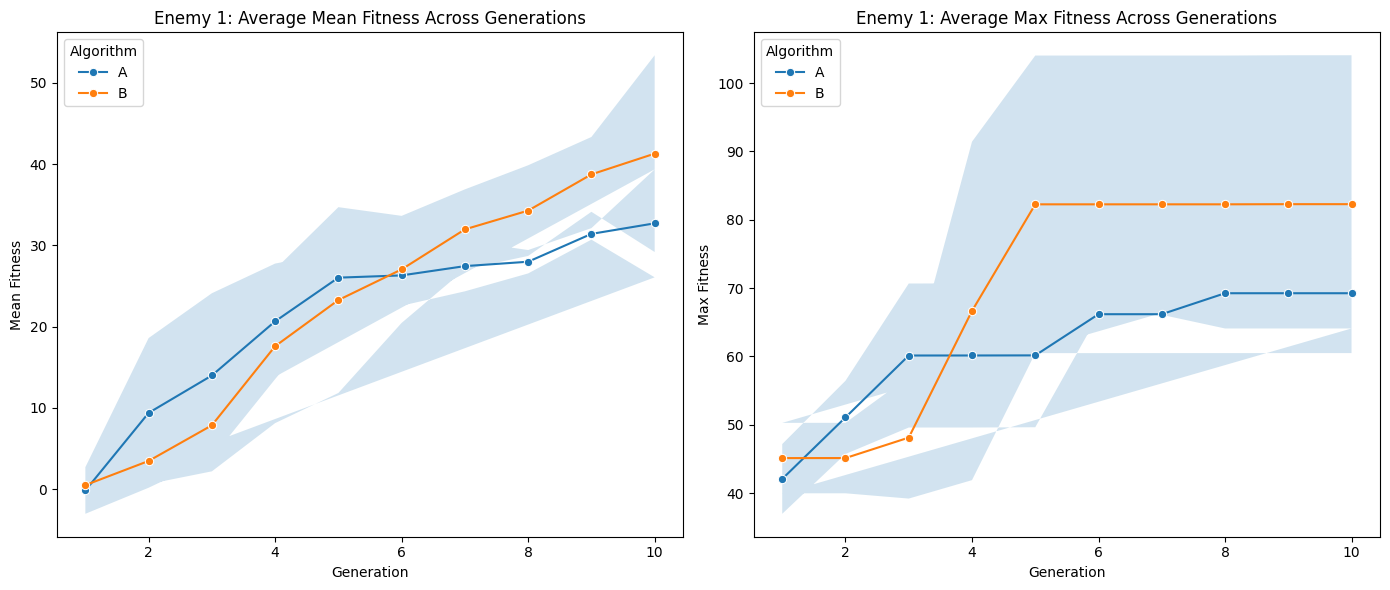

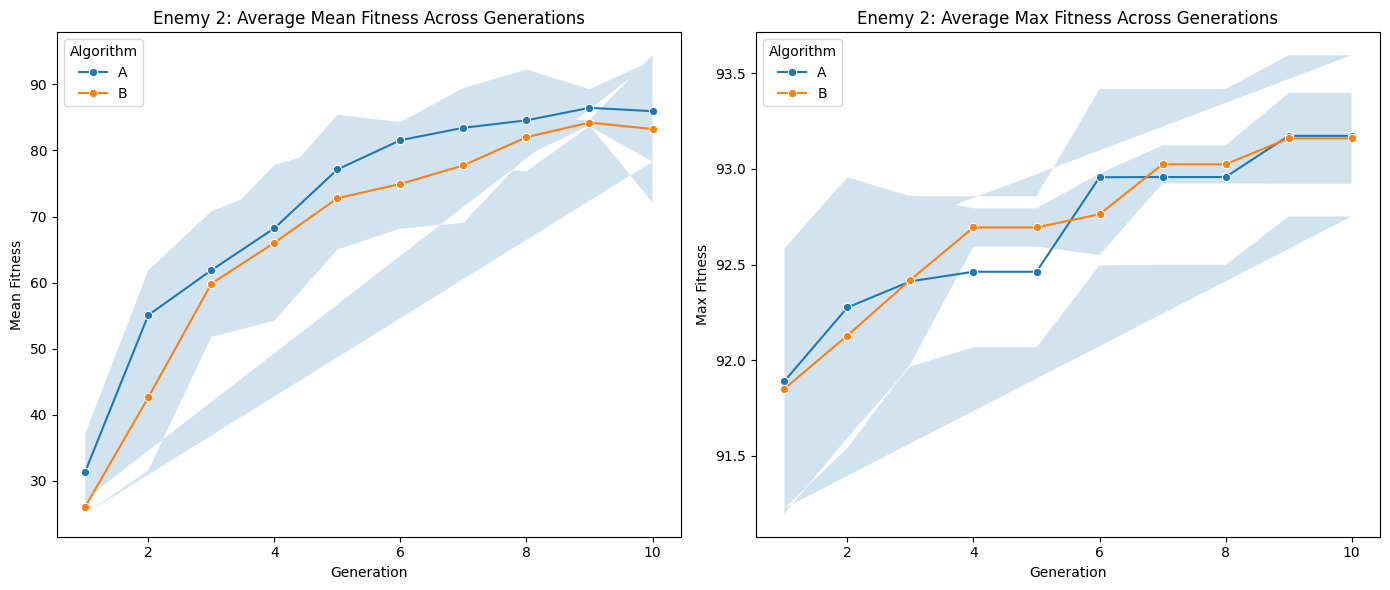

In [11]:
for enemy in enemies:
    plt.figure(figsize=(14, 6))
    
    # Subset data for the current enemy
    data_enemy = grouped[grouped['Enemy'] == enemy]
    
    # Plot Mean Fitness
    plt.subplot(1, 2, 1)
    sns.lineplot(data=data_enemy, x='Generation', y='mean_fitness_mean', hue='Algorithm', marker='o')
    plt.fill_between(
        data_enemy['Generation'],
        data_enemy['mean_fitness_mean'] - data_enemy['mean_fitness_std'],
        data_enemy['mean_fitness_mean'] + data_enemy['mean_fitness_std'],
        alpha=0.2
    )
    plt.title(f'Enemy {enemy}: Average Mean Fitness Across Generations')
    plt.xlabel('Generation')
    plt.ylabel('Mean Fitness')
    plt.legend(title='Algorithm')
    
    # Plot Max Fitness
    plt.subplot(1, 2, 2)
    sns.lineplot(data=data_enemy, x='Generation', y='max_fitness_mean', hue='Algorithm', marker='o')
    plt.fill_between(
        data_enemy['Generation'],
        data_enemy['max_fitness_mean'] - data_enemy['max_fitness_std'],
        data_enemy['max_fitness_mean'] + data_enemy['max_fitness_std'],
        alpha=0.2
    )
    plt.title(f'Enemy {enemy}: Average Max Fitness Across Generations')
    plt.xlabel('Generation')
    plt.ylabel('Max Fitness')
    plt.legend(title='Algorithm')
    
    plt.tight_layout()
    plt.show()


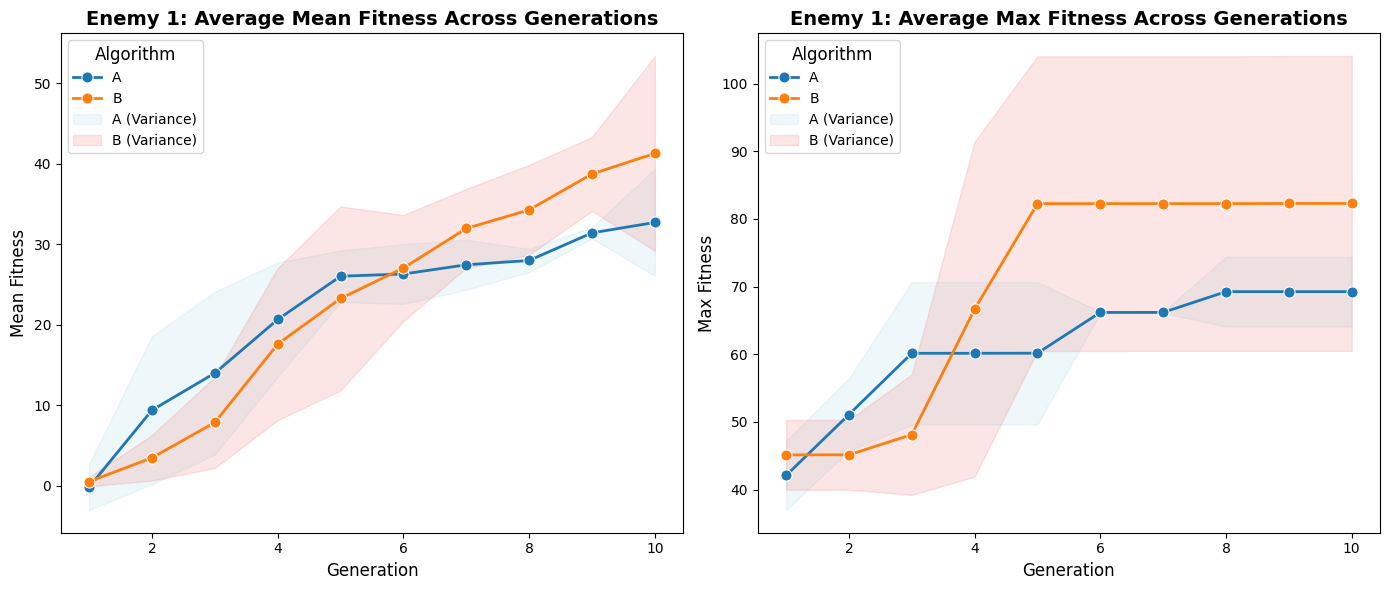

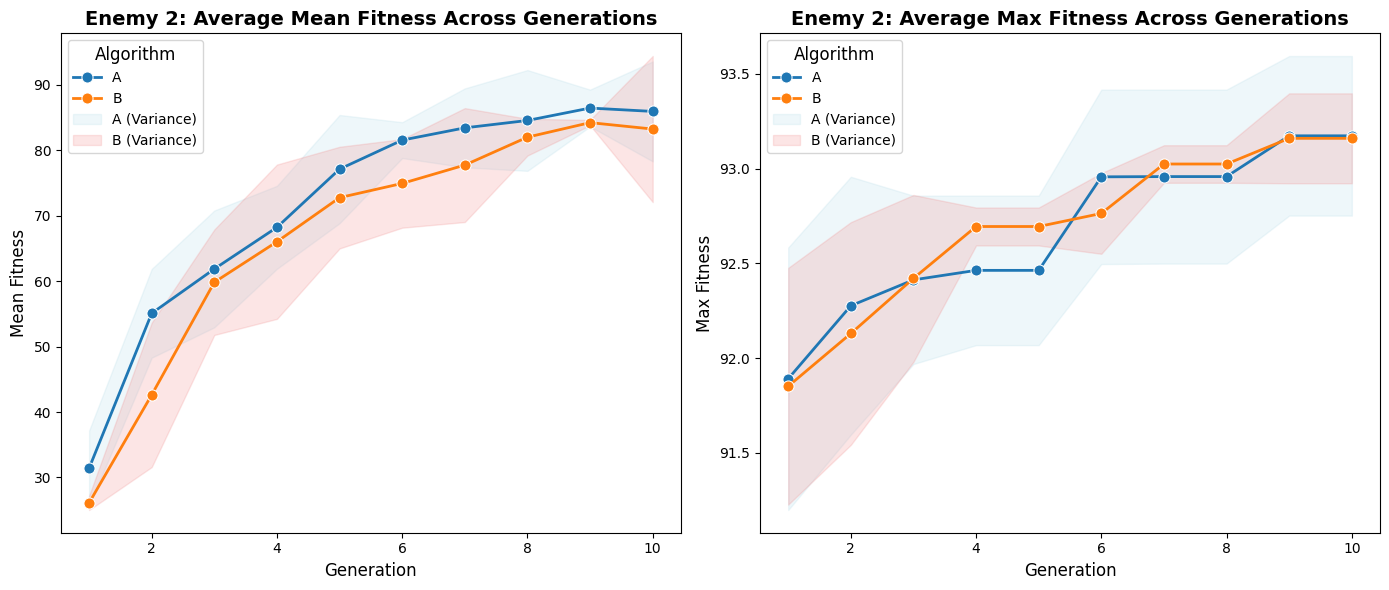

In [13]:
# Define color mapping for each algorithm
color_mapping = {'A': 'lightblue', 'B': 'lightcoral'}

for enemy in enemies:
    plt.figure(figsize=(14, 6))
    
    # Subset data for the current enemy
    data_enemy = grouped[grouped['Enemy'] == enemy]
    
    # Plot Mean Fitness
    plt.subplot(1, 2, 1)
    sns.lineplot(
        data=data_enemy, 
        x='Generation', 
        y='mean_fitness_mean', 
        hue='Algorithm', 
        marker='o', 
        linewidth=2, 
        markersize=8
    )
    
    # Fill the area for each algorithm
    for algorithm in data_enemy['Algorithm'].unique():
        subset = data_enemy[data_enemy['Algorithm'] == algorithm]
        plt.fill_between(
            subset['Generation'],
            subset['mean_fitness_mean'] - subset['mean_fitness_std'],
            subset['mean_fitness_mean'] + subset['mean_fitness_std'],
            alpha=0.2,
            color=color_mapping[algorithm],
            label=f'{algorithm} (Variance)'
        )
        
    plt.title(f'Enemy {enemy}: Average Mean Fitness Across Generations', fontsize=14, fontweight='bold')
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Mean Fitness', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title='Algorithm', title_fontsize=12, fontsize=10)
    
    # Plot Max Fitness
    plt.subplot(1, 2, 2)
    sns.lineplot(
        data=data_enemy, 
        x='Generation', 
        y='max_fitness_mean', 
        hue='Algorithm', 
        marker='o', 
        linewidth=2, 
        markersize=8
    )
    
    # Fill the area for each algorithm
    for algorithm in data_enemy['Algorithm'].unique():
        subset = data_enemy[data_enemy['Algorithm'] == algorithm]
        plt.fill_between(
            subset['Generation'],
            subset['max_fitness_mean'] - subset['max_fitness_std'],
            subset['max_fitness_mean'] + subset['max_fitness_std'],
            alpha=0.2,
            color=color_mapping[algorithm],
            label=f'{algorithm} (Variance)'
        )
        
    plt.title(f'Enemy {enemy}: Average Max Fitness Across Generations', fontsize=14, fontweight='bold')
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Max Fitness', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title='Algorithm', title_fontsize=12, fontsize=10)
    
    plt.tight_layout()
    plt.show()


In [14]:
def calculate_gain(solution, enemy, experiment_name, n_hidden_neurons, num_tests=5):
    # Create the directory if it does not exist
    os.makedirs(experiment_name, exist_ok=True)
    
    env = Environment(
        experiment_name=experiment_name,
        enemies=[enemy],
        playermode="ai",
        player_controller=player_controller(n_hidden_neurons),
        enemymode="static",
        level=2,
        speed="fastest",
        visuals=False
    )
    
    gains = []
    for _ in range(num_tests):
        f, p_e, e_e, _ = env.play(pcont=solution)
        gain = p_e - e_e
        print(f'Gain: {gain:.4f}')
        gains.append(gain)
    return gains

In [15]:
# Initialize data storage for gains
gains_data = {
	'Algorithm': [],
	'Enemy': [],
	'Run': [],
	'Gain': []
}

# Collect Gains for Best Solutions
for index, row in df_best_solutions.iterrows():
	algo = row['Algorithm']
	enemy = row['Enemy']
	run = row['Run']
	solution = row['Best Solution']
	
	n_hidden_neurons = 10
	
	# Define a unique experiment name for gain calculation
	experiment_name_gain = f'gains_{algo}_enemy_{enemy}_run_{run}'
	
	# Calculate gains
	gains = calculate_gain(solution, enemy, experiment_name_gain, n_hidden_neurons, num_tests=5)
	
	for gain in gains:
		gains_data['Algorithm'].append(algo)
		gains_data['Enemy'].append(enemy)
		gains_data['Run'].append(run)
		gains_data['Gain'].append(gain)

# Convert to DataFrame
df_gains = pd.DataFrame(gains_data)

# Display the first few rows of the gains data
df_gains.head()


MESSAGE: Pygame initialized for simulation.
Gain: -10.0000
Gain: -10.0000
Gain: -10.0000
Gain: -10.0000
Gain: -10.0000

MESSAGE: Pygame initialized for simulation.
Gain: 100.0000
Gain: 100.0000
Gain: 100.0000
Gain: 100.0000
Gain: 100.0000

MESSAGE: Pygame initialized for simulation.
Gain: -20.0000
Gain: -20.0000
Gain: -20.0000
Gain: -20.0000
Gain: -20.0000

MESSAGE: Pygame initialized for simulation.
Gain: 100.0000
Gain: 100.0000
Gain: 100.0000
Gain: 100.0000
Gain: 100.0000

MESSAGE: Pygame initialized for simulation.
Gain: -20.0000
Gain: -20.0000
Gain: -20.0000
Gain: -20.0000
Gain: -20.0000

MESSAGE: Pygame initialized for simulation.
Gain: -30.0000
Gain: -30.0000
Gain: -30.0000
Gain: -30.0000
Gain: -30.0000

MESSAGE: Pygame initialized for simulation.
Gain: 86.0000
Gain: 86.0000
Gain: 86.0000
Gain: 86.0000
Gain: 86.0000

MESSAGE: Pygame initialized for simulation.
Gain: 84.0000
Gain: 84.0000
Gain: 84.0000
Gain: 84.0000
Gain: 84.0000

MESSAGE: Pygame initialized for simulation.
Gain:

,Algorithm,Enemy,Run,Gain
0,A,1,1,-10.0
1,A,1,1,-10.0
2,A,1,1,-10.0
3,A,1,1,-10.0
4,A,1,1,-10.0


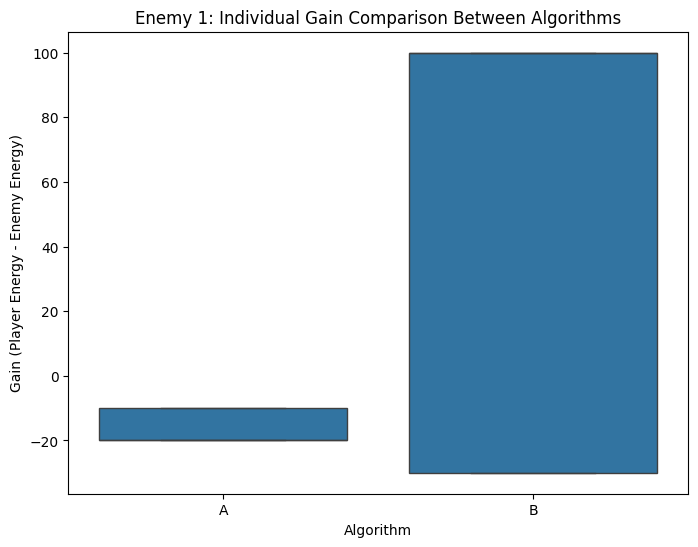

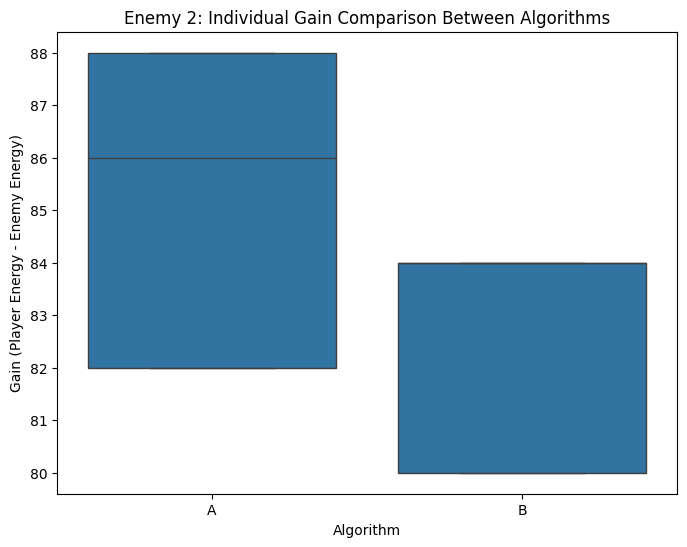

In [16]:
for enemy in enemies:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_gains[(df_gains['Enemy'] == enemy)], x='Algorithm', y='Gain')
    plt.title(f'Enemy {enemy}: Individual Gain Comparison Between Algorithms')
    plt.xlabel('Algorithm')
    plt.ylabel('Gain (Player Energy - Enemy Energy)')
    plt.show()

In [17]:
# Compute mean gain per run for each algorithm and enemy
mean_gains = df_gains.groupby(['Algorithm', 'Enemy', 'Run']).agg(
    mean_gain=('Gain', 'mean')
).reset_index()


In [18]:
for enemy in enemies:
    # Extract mean gains for each algorithm
    gains_a = mean_gains[(mean_gains['Enemy'] == enemy) & (mean_gains['Algorithm'] == 'A')]['mean_gain']
    gains_b = mean_gains[(mean_gains['Enemy'] == enemy) & (mean_gains['Algorithm'] == 'B')]['mean_gain']
    
    # Perform t-test
    t_stat, p_val_t = ttest_ind(gains_a, gains_b, equal_var=False)
    
    # Perform Mann-Whitney U test
    u_stat, p_val_u = mannwhitneyu(gains_a, gains_b, alternative='two-sided')
    
    print(f"\nStatistical Test Results for Enemy {enemy}:")
    print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {p_val_t:.4f}")
    print(f"Mann-Whitney U test: U-statistic = {u_stat}, p-value = {p_val_u:.4f}")
    
    if p_val_t < 0.05:
        print("Result: Significant difference in mean gains (t-test).")
    else:
        print("Result: No significant difference in mean gains (t-test).")
        
    if p_val_u < 0.05:
        print("Result: Significant difference in mean gains (Mann-Whitney U test).")
    else:
        print("Result: No significant difference in mean gains (Mann-Whitney U test).")



Statistical Test Results for Enemy 1:
T-test: t-statistic = -1.6873, p-value = 0.2321
Mann-Whitney U test: U-statistic = 3.0, p-value = 0.6531
Result: No significant difference in mean gains (t-test).
Result: No significant difference in mean gains (Mann-Whitney U test).

Statistical Test Results for Enemy 2:
T-test: t-statistic = 1.2060, p-value = 0.2988
Mann-Whitney U test: U-statistic = 7.0, p-value = 0.3758
Result: No significant difference in mean gains (t-test).
Result: No significant difference in mean gains (Mann-Whitney U test).
